#  Trading Strategy

In this section, we explore how to design and evaluate trading strategies using the predictions of two different machine learning models. These predictions are used to drive different portfolio management strategies, allowing us to compare how each approach behaves under various market conditions.

In [55]:
# 1. Setup and Data Import
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Load data (edit path if needed)
df = pd.read_csv("data/ENRICH/merged_stock_income.csv", parse_dates=["Date"])
df.set_index("Date", inplace=True)

#  LogisticRegression

Here, we decided to compare 3 different trading strategies using the same prediction model (logistic regression), which is a binary classification model that predicts whether the stock price will **increase (1)** or **decrease (0)** the next day.

1. **Fixed Units Strategy**
   - **Buy 1 share** if the model predicts a rise, **sell 1 share** if it predicts a fall.
   - Simple and conservative. Good to test model signal quality with low risk.

2. **Full Volume Strategy**
   - Buy as many shares as possible with all available cash if a rise is predicted.
   - Sell all holdings if a fall is predicted.
   - More aggressive and high-risk/reward compared to fixed units.

3. **Threshold + Sizing Strategy**
   - Trades only when the **log-return exceeds a given threshold** (e.g., ±0.5%).
   - Buys or sells a **percentage of the capital or holdings** (e.g., 20%) when triggered.
   - Designed to filter noise and scale trade size with signal strength.
   - More flexible and realistic for real-world portfolio management.

In [56]:
# 2. Utility Functions
def prepare_data(ticker):
    """Extracts, transforms, and returns data for one ticker."""
    ticker_df = df[df["Ticker"] == ticker].copy()
    ticker_df["Log_Returns"] = np.log(ticker_df["Close"] / ticker_df["Close"].shift(1))
    ticker_df["Lag1"] = ticker_df["Log_Returns"].shift(1)
    ticker_df["Lag2"] = ticker_df["Log_Returns"].shift(2)
    ticker_df["Target"] = (ticker_df["Close"].shift(-1) > ticker_df["Close"]).astype(int)
    return ticker_df.dropna(subset=["Lag1", "Lag2", "Target"])

def train_model(model_data):
    X = model_data[["Lag1", "Lag2"]]
    y = model_data["Target"]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    return clf, scaler, X_test, y_test

In [57]:
# 3. Strategy Functions
def strategy_fixed_units(prices, predictions, initial_cash=1000):
    cash, shares = initial_cash, 0
    history = []
    for pred, price in zip(predictions, prices):
        if pred == 1 and cash >= price:
            shares += 1
            cash -= price
        elif pred == 0 and shares > 0:
            shares -= 1
            cash += price
        history.append(cash + shares * price)
    return history

def strategy_full_volume(prices, predictions, initial_cash=1000):
    cash, shares = initial_cash, 0
    history = []
    for pred, price in zip(predictions, prices):
        if pred == 1 and cash >= price:
            qty = int(cash // price)
            shares += qty
            cash -= qty * price
        elif pred == 0 and shares > 0:
            cash += shares * price
            shares = 0
        history.append(cash + shares * price)
    return history

def strategy_threshold_dynamic(data, model, scaler, test_index, investment_fraction=0.2, threshold=0.005, initial_cash=1000):
    data = data.copy()
    cash = initial_cash
    shares = 0
    history = []

    for i in range(2, len(data)):
        if data.index[i] not in test_index:
            continue
        row = data.iloc[i - 1][["Lag1", "Lag2"]].to_frame().T
        log_return = data.iloc[i]["Log_Returns"]
        scaled = scaler.transform(row)
        prediction = model.predict(scaled)[0]
        price = data.iloc[i]["Close"]
        #print(f"Day {i}, Log Return: {log_return:.4f}, Prediction: {prediction}, Cash: {cash:.2f}, Shares: {shares}")

        if log_return > threshold and cash >= price:
            invest_amt = cash * investment_fraction
            qty = int(invest_amt // price)
            shares += qty
            cash -= qty * price
        elif log_return < -threshold and shares > 0:
            sell_qty = int(shares * investment_fraction)
            shares -= sell_qty
            cash += sell_qty * price

        portfolio_value = cash + shares * price
        history.append(portfolio_value)

    return history

In [58]:
# 4. Backtest and Visualization
def evaluate_strategy(ticker):
    data = prepare_data(ticker)
    clf, scaler, X_test, y_test = train_model(data)
    y_pred = clf.predict(X_test)
    prices = data.loc[y_test.index, "Close"].values

    # Strategy 1: fixed units
    fixed = strategy_fixed_units(prices, y_pred)
    # Strategy 2: full volume
    full = strategy_full_volume(prices, y_pred)
    # Strategy 3: dynamic threshold strategy
    thresholded = strategy_threshold_dynamic(data, clf, scaler, y_test.index)

    # Plot results
    plt.figure(figsize=(12, 5))
    plt.plot(fixed, label="Fixed Units")
    plt.plot(full, label="Full Volume")
    plt.plot(thresholded, label="Threshold + Sizing")
    plt.title(f"{ticker} - Portfolio Value Comparison")
    plt.xlabel("Days")
    plt.ylabel("Portfolio Value ($)")
    plt.legend()
    plt.grid(True)
    plt.show()

    return fixed[-1], full[-1], thresholded[-1]

**Now, let's compare the results for 5 different tickers, each evaluated using the 3 trading strategies above.**


Evaluating: CRWD
Day 953, Log Return: 0.0162, Prediction: 1, Cash: 1000.00, Shares: 0
Day 954, Log Return: 0.0412, Prediction: 1, Cash: 868.28, Shares: 1
Day 955, Log Return: -0.0052, Prediction: 1, Cash: 731.02, Shares: 2
Day 956, Log Return: 0.0023, Prediction: 0, Cash: 731.02, Shares: 2
Day 957, Log Return: -0.0685, Prediction: 1, Cash: 731.02, Shares: 2
Day 958, Log Return: 0.0002, Prediction: 1, Cash: 731.02, Shares: 2
Day 959, Log Return: 0.0022, Prediction: 1, Cash: 731.02, Shares: 2
Day 960, Log Return: 0.0136, Prediction: 1, Cash: 731.02, Shares: 2
Day 961, Log Return: 0.0388, Prediction: 1, Cash: 601.16, Shares: 3
Day 962, Log Return: 0.0081, Prediction: 1, Cash: 601.16, Shares: 3
Day 963, Log Return: -0.0024, Prediction: 0, Cash: 601.16, Shares: 3
Day 964, Log Return: 0.0117, Prediction: 1, Cash: 601.16, Shares: 3
Day 965, Log Return: -0.0072, Prediction: 1, Cash: 601.16, Shares: 3
Day 966, Log Return: -0.0264, Prediction: 1, Cash: 601.16, Shares: 3
Day 967, Log Return: -0.

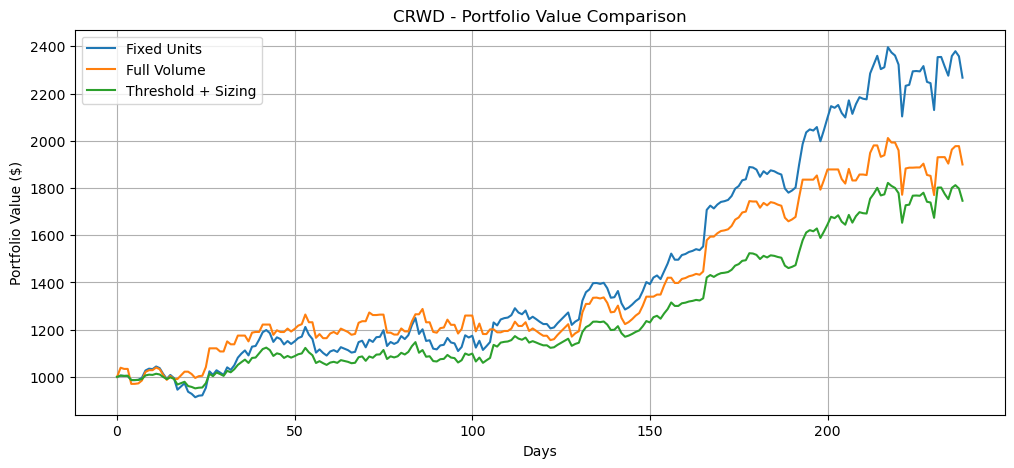


Evaluating: PG
Day 987, Log Return: -0.0006, Prediction: 1, Cash: 1000.00, Shares: 0
Day 988, Log Return: -0.0014, Prediction: 1, Cash: 1000.00, Shares: 0
Day 989, Log Return: 0.0202, Prediction: 1, Cash: 1000.00, Shares: 0
Day 990, Log Return: -0.0053, Prediction: 1, Cash: 853.28, Shares: 1
Day 991, Log Return: 0.0028, Prediction: 1, Cash: 853.28, Shares: 1
Day 992, Log Return: 0.0031, Prediction: 0, Cash: 853.28, Shares: 1
Day 993, Log Return: 0.0043, Prediction: 1, Cash: 853.28, Shares: 1
Day 994, Log Return: 0.0084, Prediction: 1, Cash: 853.28, Shares: 1
Day 995, Log Return: 0.0055, Prediction: 1, Cash: 704.59, Shares: 2
Day 996, Log Return: 0.0048, Prediction: 1, Cash: 704.59, Shares: 2
Day 997, Log Return: 0.0068, Prediction: 1, Cash: 704.59, Shares: 2
Day 998, Log Return: 0.0063, Prediction: 1, Cash: 704.59, Shares: 2
Day 999, Log Return: -0.0083, Prediction: 1, Cash: 704.59, Shares: 2
Day 1000, Log Return: -0.0020, Prediction: 1, Cash: 704.59, Shares: 2
Day 1001, Log Return: 0

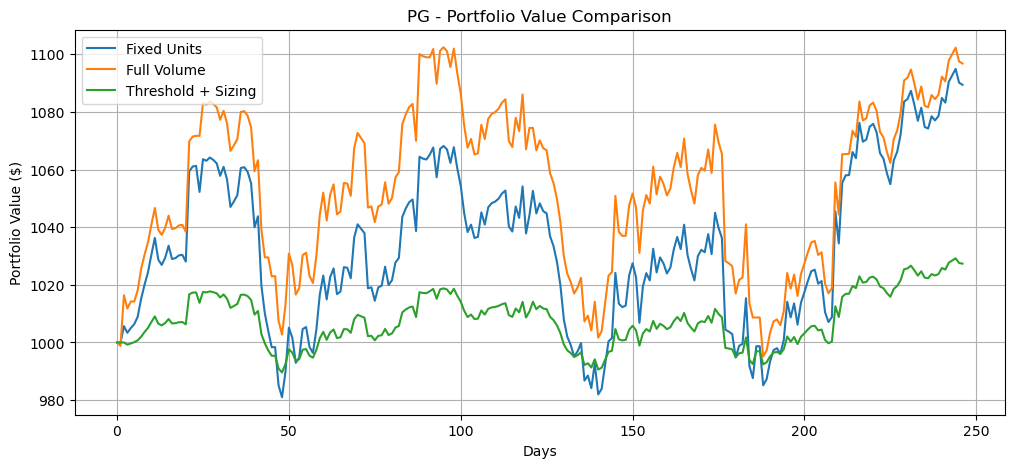


Evaluating: MSFT
Day 988, Log Return: -0.0055, Prediction: 1, Cash: 1000.00, Shares: 0
Day 989, Log Return: 0.0195, Prediction: 1, Cash: 1000.00, Shares: 0
Day 990, Log Return: 0.0104, Prediction: 1, Cash: 1000.00, Shares: 0
Day 991, Log Return: -0.0150, Prediction: 1, Cash: 1000.00, Shares: 0
Day 992, Log Return: -0.0042, Prediction: 1, Cash: 1000.00, Shares: 0
Day 993, Log Return: 0.0190, Prediction: 1, Cash: 1000.00, Shares: 0
Day 994, Log Return: 0.0125, Prediction: 1, Cash: 1000.00, Shares: 0
Day 995, Log Return: 0.0149, Prediction: 1, Cash: 1000.00, Shares: 0
Day 996, Log Return: -0.0037, Prediction: 1, Cash: 1000.00, Shares: 0
Day 997, Log Return: -0.0002, Prediction: 1, Cash: 1000.00, Shares: 0
Day 998, Log Return: -0.0099, Prediction: 1, Cash: 1000.00, Shares: 0
Day 999, Log Return: 0.0252, Prediction: 1, Cash: 1000.00, Shares: 0
Day 1000, Log Return: -0.0076, Prediction: 1, Cash: 1000.00, Shares: 0
Day 1001, Log Return: -0.0229, Prediction: 1, Cash: 1000.00, Shares: 0
Day 10

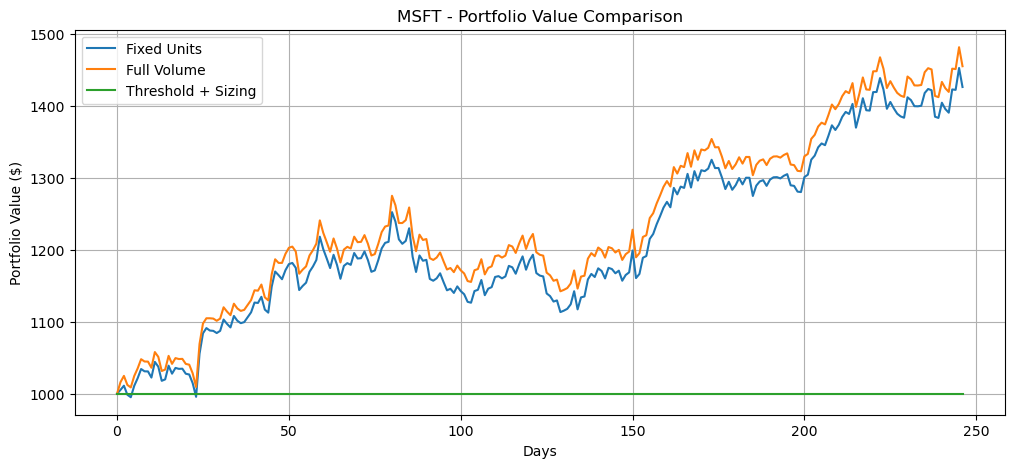


Evaluating: NVDA
Day 986, Log Return: 0.0268, Prediction: 1, Cash: 1000.00, Shares: 0
Day 987, Log Return: -0.0152, Prediction: 1, Cash: 809.67, Shares: 7
Day 988, Log Return: -0.0094, Prediction: 1, Cash: 836.45, Shares: 6
Day 989, Log Return: -0.0045, Prediction: 1, Cash: 862.98, Shares: 5
Day 990, Log Return: 0.0214, Prediction: 1, Cash: 862.98, Shares: 5
Day 991, Log Return: 0.0147, Prediction: 1, Cash: 701.10, Shares: 11
Day 992, Log Return: 0.0145, Prediction: 1, Cash: 564.20, Shares: 16
Day 993, Log Return: 0.0065, Prediction: 1, Cash: 453.08, Shares: 20
Day 994, Log Return: -0.0184, Prediction: 1, Cash: 369.20, Shares: 23
Day 995, Log Return: -0.0210, Prediction: 1, Cash: 479.00, Shares: 19
Day 996, Log Return: 0.0059, Prediction: 1, Cash: 559.64, Shares: 16
Day 997, Log Return: 0.0198, Prediction: 1, Cash: 451.48, Shares: 20
Day 998, Log Return: -0.0150, Prediction: 1, Cash: 368.74, Shares: 23
Day 999, Log Return: -0.0250, Prediction: 1, Cash: 477.42, Shares: 19
Day 1000, Log

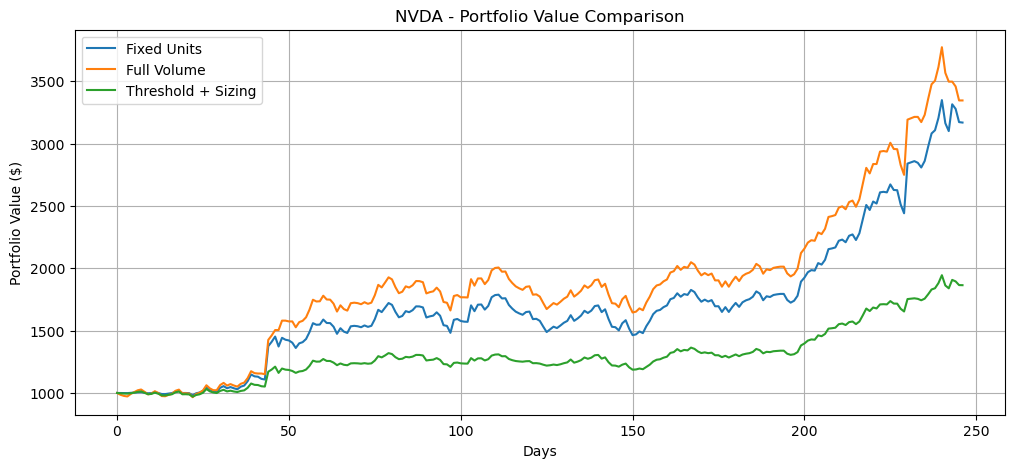


Evaluating: TSLA
Day 987, Log Return: 0.0753, Prediction: 1, Cash: 1000.00, Shares: 0
Day 988, Log Return: -0.0331, Prediction: 1, Cash: 802.42, Shares: 1
Day 989, Log Return: 0.0056, Prediction: 1, Cash: 802.42, Shares: 1
Day 990, Log Return: -0.0095, Prediction: 1, Cash: 802.42, Shares: 1
Day 991, Log Return: 0.0073, Prediction: 1, Cash: 802.42, Shares: 1
Day 992, Log Return: -0.0138, Prediction: 1, Cash: 802.42, Shares: 1
Day 993, Log Return: 0.0245, Prediction: 1, Cash: 802.42, Shares: 1
Day 994, Log Return: 0.0072, Prediction: 1, Cash: 802.42, Shares: 1
Day 995, Log Return: 0.0605, Prediction: 1, Cash: 802.42, Shares: 1
Day 996, Log Return: -0.0631, Prediction: 1, Cash: 802.42, Shares: 1
Day 997, Log Return: -0.0113, Prediction: 1, Cash: 802.42, Shares: 1
Day 998, Log Return: -0.0373, Prediction: 1, Cash: 802.42, Shares: 1
Day 999, Log Return: -0.0025, Prediction: 1, Cash: 802.42, Shares: 1
Day 1000, Log Return: -0.0030, Prediction: 1, Cash: 802.42, Shares: 1
Day 1001, Log Return

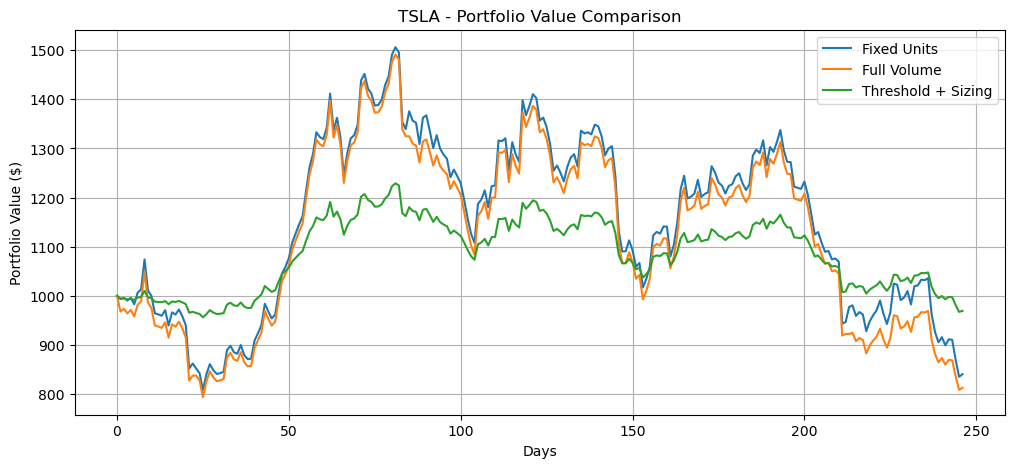

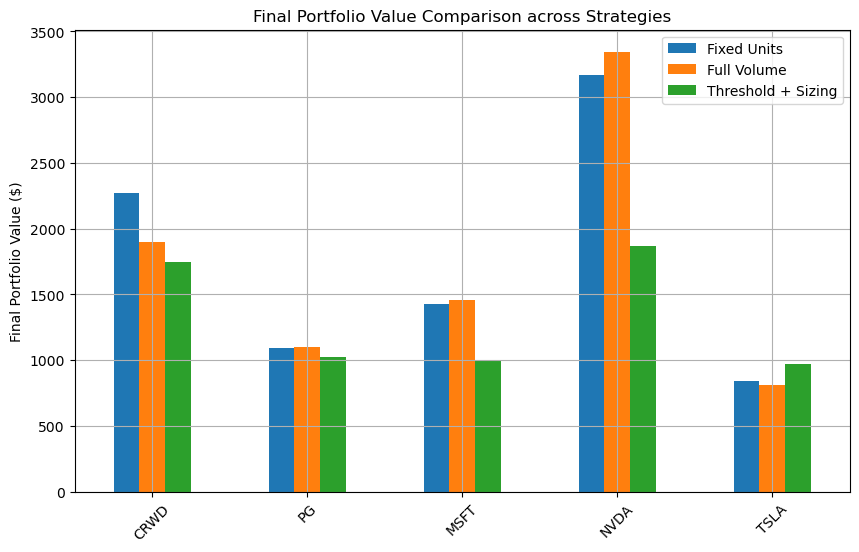

,Fixed Units,Full Volume,Threshold + Sizing
CRWD,2267.45,1899.84,1746.09
PG,1089.42,1096.80,1027.35
MSFT,1426.36,1455.25,1000.00
NVDA,3168.75,3346.04,1864.35
TSLA,840.40,812.78,969.37


In [59]:
# 5. Multi-Ticker Comparison
tickers = ["CRWD", "PG", "MSFT", "NVDA", "TSLA"]
results = {}

for t in tickers:
    print(f"\nEvaluating: {t}")
    fixed_val, full_val, thresh_val = evaluate_strategy(t)
    results[t] = {
        "Fixed Units": fixed_val,
        "Full Volume": full_val,
        "Threshold + Sizing": thresh_val
    }

# Final comparison
summary_df = pd.DataFrame(results).T
summary_df.plot(kind="bar", figsize=(10, 6))
plt.title("Final Portfolio Value Comparison across Strategies")
plt.ylabel("Final Portfolio Value ($)")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

summary_df

This comparison highlights how portfolio performance can vary significantly depending on the strategy applied, even when using identical predictions.

The **Fixed Units strategy** applies model predictions in a uniform way by buying or selling one unit per signal. It shows relatively stable results across different tickers and provides a simple way to assess the raw predictive quality of the model without taking large position risks.

The **Full Volume strategy** uses the model’s predictions to fully invest or fully divest, which can lead to larger gains when the stock follows a clear trend. However, the results also show that this strategy may amplify fluctuations depending on the stock’s behavior.

The **Threshold + Sizing strategy** only acts when the expected return surpasses a given threshold, and scales the position size accordingly. This leads to fewer but more selective trades. In some cases, this results in lower performance when few signals are triggered or when the threshold is too strict (e.g., with MSFT).

#  MultiClass Regression

Here, we shift from binary classification to a **regression model**, which tries to predict the actual **closing price of the next day**.

We apply the regression output to guide trading decisions based on **expected return**:

1. **Confidence-Based Strategy**
   - Computes expected return: `(predicted_price - current_price) / current_price`
   - Only acts (buy/sell) if this return is above a confidence threshold (e.g., ±1%)
   - Buys 1 share if strong upward move is predicted, sells 1 share if strong drop expected.
   - Very dependent on prediction accuracy.

➡️ This strategy provides more flexibility than classification, but requires more precise predictions. It also allows for dynamic sizing or profit-target logic in more advanced extensions.

In [60]:
def train_ticker_model(ticker, save=True):
    """
    Loads data from file, filters by ticker, computes target labels,
    and trains a multi-class LightGBM model.
    Returns:
        model: Trained LightGBM model
        df: Cleaned DataFrame used for training
    """
    df = pd.read_csv(DATA_PATH, parse_dates=["Date"])
    df.set_index("Date", inplace=True)
    df = df[df["Ticker"] == ticker].copy()
    df = df.sort_index().drop_duplicates()

    # Compute target
    df["Future_Price_Change%"] = ((df["Close"].shift(-1) - df["Close"]) / df["Close"]) * 100

    def label_change(pct):
        if pct < -2.5:
            return 'High Fall'
        elif -2.5 <= pct < -0.1:
            return 'Low Fall'
        elif -0.1 <= pct <= 0.1:
            return 'Stay'
        elif 0.1 < pct <= 2.5:
            return 'Low Rise'
        else:
            return 'High Rise'
    
      # ✅ Drop any rows with nulls in any column
    df = df.dropna()

    df["Class"] = df["Future_Price_Change%"].apply(label_change)

    features = [
        'Open', 'High', 'Low', 'Close', 'Volume',
        'Shares Outstanding', 'Daily_Return', 'MA_5', 'MA_10',
    ]

    # Convert and clean
    df[features] = df[features].apply(pd.to_numeric, errors="coerce")
    
  

    X = df[features]
    y = df["Class"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    model = LGBMClassifier(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print("✅ Test Accuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%")
    print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
    print("🔍 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    if save:
        dump(model, MODEL_FILENAME)
        print(f"💾 Model saved as '{MODEL_FILENAME}'")

    return model, df


In [61]:
_, df=train_ticker_model('CRWD')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2066
[LightGBM] [Info] Number of data points in the train set: 955, number of used features: 9
[LightGBM] [Info] Start training from score -1.583597
[LightGBM] [Info] Start training from score -1.500419
[LightGBM] [Info] Start training from score -1.364543
[LightGBM] [Info] Start training from score -1.237694
[LightGBM] [Info] Start training from score -3.642836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
✅ Test Accuracy: 28.03 %

📊 Classification Report:
               precision    recall  f1-score   support

   High Fall       0.23      0.20      0.22        49
   High Rise       0.32      0.20      0.25        54
    Low Fall       0.32      0.39      0.35        61
    Low Rise       0

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [62]:
# Ensure 'Date' is datetime index
df.index = pd.to_datetime(df.index)

# Filter for CRWD, first week of October 2024
crwd_oct_week1 = df[
    (df["Ticker"] == "CRWD") &
    (df.index >= "2023-10-01") &
    (df.index < "2023-10-08")
][["Close", "Future_Price_Change%","Class"]]

# Display result
print(crwd_oct_week1)

             Close  Future_Price_Change%      Class
Date                                               
2023-10-02  169.54             -4.429633  High Fall
2023-10-03  162.03              1.246683   Low Rise
2023-10-04  164.05              0.755867   Low Rise
2023-10-05  165.29              6.896969  High Rise
2023-10-06  176.69              2.903390  High Rise


**Stategy**

1. strategy_fixed_units_multiclass



In [63]:
def strategy_fixed_units_multiclass(prices, predictions, initial_cash=1000):
    cash, shares = initial_cash, 0
    history = []

    for pred, price in zip(predictions, prices):
        if pred in ["Low Rise", "High Rise"] and cash >= price:
            shares += 1
            cash -= price
        elif pred in ["Low Fall", "High Fall"] and shares > 0:
            shares -= 1
            cash += price
        # "Stay" does nothing
        history.append(cash + shares * price)

    return history


2. strategy_full_volume_multiclass


In [64]:
def strategy_full_volume_multiclass(prices, predictions, initial_cash=1000):
    cash, shares = initial_cash, 0
    history = []

    for pred, price in zip(predictions, prices):
        # Buy only if you don't already hold shares
        if pred in ["Low Rise", "High Rise"] and shares == 0 and cash >= price:
            qty = int(cash // price)
            shares += qty
            cash -= qty * price

        # Sell only if you actually hold shares
        elif pred in ["Low Fall", "High Fall"] and shares > 0:
            cash += shares * price
            shares = 0

        # Hold if "Stay" or no condition met
        history.append(cash + shares * price)

    return history


3. strategy_threshold_dynamic_multiclass


In [65]:
def strategy_threshold_dynamic_multiclass(data, model, test_index, investment_fraction=0.2, threshold=0.005, initial_cash=1000):
    data = data.copy()
    cash = initial_cash
    shares = 0
    history = []

    features = ['Open', 'High', 'Low', 'Close', 'Volume', 
                'Shares Outstanding', 'Daily_Return', 'MA_5', 'MA_10']

    for i in range(2, len(data)):
        if data.index[i] not in test_index:
            continue

        row = data.iloc[i - 1][features].to_frame().T
        row = row.apply(pd.to_numeric, errors="coerce")  # ✅ Make row numeric

        price = data.iloc[i]["Close"]
        log_return = data.iloc[i]["Daily_Return"]  # or Log_Returns if available

        prediction = model.predict(row)[0]

        #print(f"Day {i}, Predicted Class: {prediction}, Log Return: {log_return:.4f}, Cash: {cash:.2f}, Shares: {shares}")

        if prediction in ["Low Rise", "High Rise"] and log_return > threshold and cash >= price:
            invest_amt = cash * investment_fraction
            qty = int(invest_amt // price)
            shares += qty
            cash -= qty * price
        elif prediction in ["Low Fall", "High Fall"] and log_return < -threshold and shares > 0:
            sell_qty = int(shares * investment_fraction)
            shares -= sell_qty
            cash += sell_qty * price

        portfolio_value = cash + shares * price
        history.append(portfolio_value)

    return history


In [66]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def evaluate_strategy(ticker):
    # 1. Train model and get cleaned data
    model, processed_df = train_ticker_model(ticker)

    # 2. Use already-processed DataFrame
    features = [
        'Open', 'High', 'Low', 'Close', 'Volume',
        'Shares Outstanding', 'Daily_Return', 'MA_5', 'MA_10',
    ]
    X = processed_df[features]
    y = processed_df['Class']

    # 3. Split same as in model training
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    y_pred = model.predict(X_test)
    prices = X_test["Close"].values


    # 4. Run strategies
    fixed = strategy_fixed_units_multiclass(prices, y_pred)
    full = strategy_full_volume_multiclass(prices, y_pred)
    thresholded = strategy_threshold_dynamic_multiclass(processed_df, model, X_test.index)

    # 5. Plot results
    plt.figure(figsize=(12, 5))
    plt.plot(fixed, label="Fixed Units")
    plt.plot(full, label="Full Volume")
    plt.plot(thresholded, label="Threshold + Sizing")
    plt.title(f"{ticker} - Portfolio Value Comparison")
    plt.xlabel("Days")
    plt.ylabel("Portfolio Value ($)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return fixed[-1], full[-1], thresholded[-1]




🚀 Evaluating: CRWD
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2066
[LightGBM] [Info] Number of data points in the train set: 955, number of used features: 9
[LightGBM] [Info] Start training from score -1.583597
[LightGBM] [Info] Start training from score -1.500419
[LightGBM] [Info] Start training from score -1.364543
[LightGBM] [Info] Start training from score -1.237694
[LightGBM] [Info] Start training from score -3.642836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
✅ Test Accuracy: 28.03 %

📊 Classification Report:
               precision    recall  f1-score   support

   High Fall       0.23      0.20      0.22        49
   High Rise       0.32      0.20      0.25        54
    Low Fall       0.32      0.39      0.35        61


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Day 2, Predicted Class: High Fall, Log Return: 1682.2222, Cash: 1000.00, Shares: 0
Day 4, Predicted Class: High Rise, Log Return: -36.9592, Cash: 1000.00, Shares: 0
Day 5, Predicted Class: High Rise, Log Return: 165.3608, Cash: 1000.00, Shares: 0
Day 10, Predicted Class: Low Rise, Log Return: -46.2001, Cash: 845.56, Shares: 2
Day 17, Predicted Class: Low Fall, Log Return: 41.4289, Cash: 845.56, Shares: 2
Day 24, Predicted Class: Low Rise, Log Return: 698.6502, Cash: 845.56, Shares: 2
Day 26, Predicted Class: High Rise, Log Return: 725.2964, Cash: 703.56, Shares: 4
Day 28, Predicted Class: Low Fall, Log Return: 123.7297, Cash: 620.04, Shares: 5
Day 48, Predicted Class: Low Fall, Log Return: 412.9850, Cash: 620.04, Shares: 5
Day 58, Predicted Class: Low Rise, Log Return: 233.3724, Cash: 620.04, Shares: 5
Day 59, Predicted Class: Low Fall, Log Return: 72275.0000, Cash: 534.73, Shares: 6
Day 60, Predicted Class: High Fall, Log Return: 654.5184, Cash: 534.73, Shares: 6
Day 85, Predicted Cla

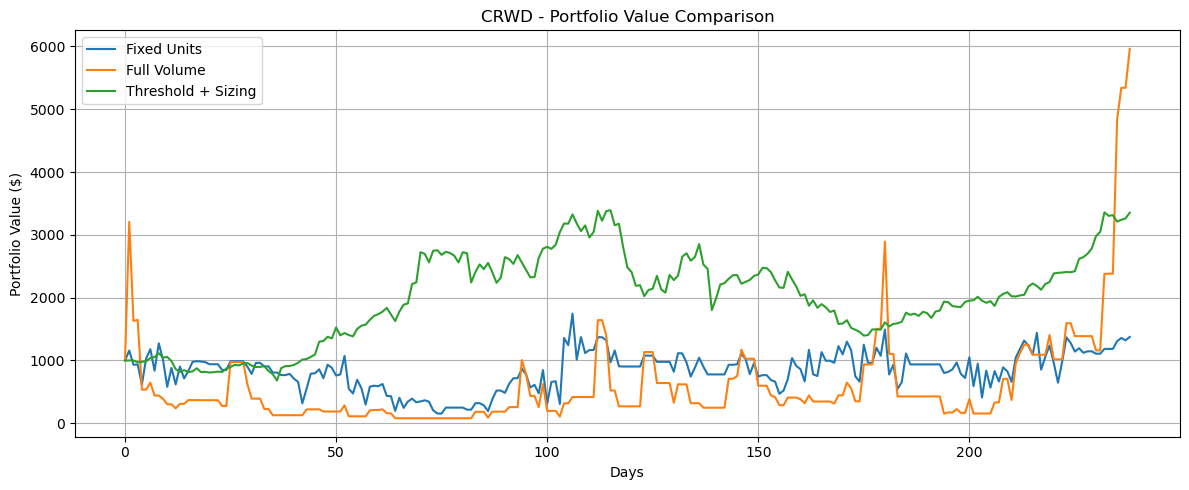


🚀 Evaluating: PG
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2057
[LightGBM] [Info] Number of data points in the train set: 988, number of used features: 9
[LightGBM] [Info] Start training from score -3.599846
[LightGBM] [Info] Start training from score -3.676807
[LightGBM] [Info] Start training from score -0.939845
[LightGBM] [Info] Start training from score -0.779791
[LightGBM] [Info] Start training from score -2.320972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
✅ Test Accuracy: 41.53 %

📊 Classification Report:
               precision    recall  f1-score   support

   High Fall       0.00      0.00      0.00         7
   High Rise       0.00      0.00  

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Day 7, Predicted Class: Low Rise, Log Return: 46.8489, Cash: 1000.00, Shares: 0
Day 8, Predicted Class: Low Rise, Log Return: -65.0136, Cash: 896.31, Shares: 1
Day 12, Predicted Class: Low Fall, Log Return: 497.2112, Cash: 896.31, Shares: 1
Day 14, Predicted Class: Low Rise, Log Return: 1209.6296, Cash: 896.31, Shares: 1
Day 16, Predicted Class: Low Fall, Log Return: 169.4981, Cash: 790.23, Shares: 2
Day 23, Predicted Class: Low Rise, Log Return: -99.9990, Cash: 790.23, Shares: 2
Day 37, Predicted Class: Low Rise, Log Return: 225.1969, Cash: 790.23, Shares: 2
Day 43, Predicted Class: Low Rise, Log Return: 43.1698, Cash: 682.85, Shares: 3
Day 46, Predicted Class: Low Rise, Log Return: -66.4784, Cash: 571.65, Shares: 4
Day 51, Predicted Class: Low Fall, Log Return: -94.0045, Cash: 571.65, Shares: 4
Day 55, Predicted Class: Low Rise, Log Return: -5.2041, Cash: 571.65, Shares: 4
Day 70, Predicted Class: Low Fall, Log Return: 309.3057, Cash: 571.65, Shares: 4
Day 72, Predicted Class: Low Ri

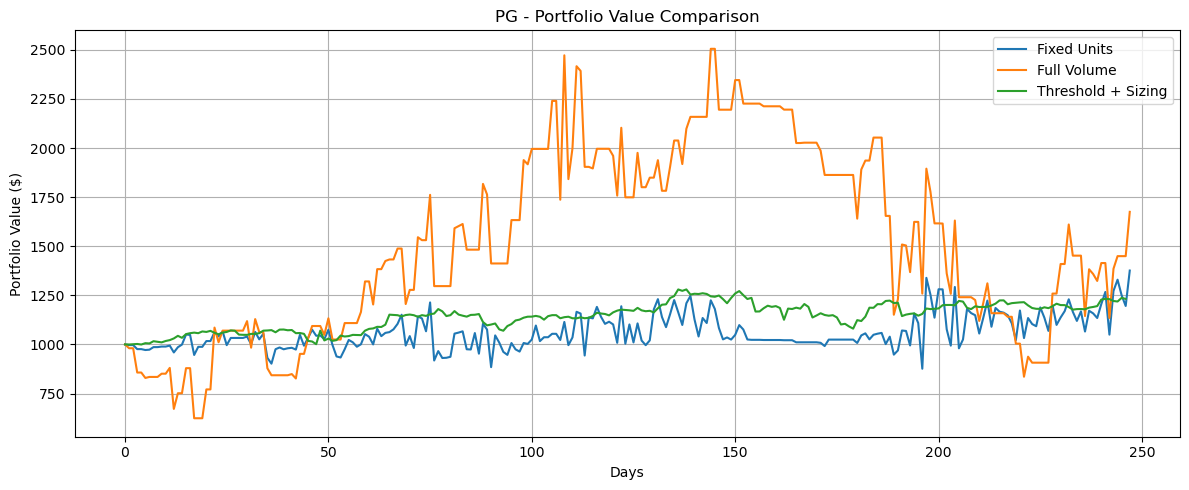


🚀 Evaluating: MSFT
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2066
[LightGBM] [Info] Number of data points in the train set: 989, number of used features: 9
[LightGBM] [Info] Start training from score -2.634014
[LightGBM] [Info] Start training from score -2.648199
[LightGBM] [Info] Start training from score -1.007816
[LightGBM] [Info] Start training from score -0.846961
[LightGBM] [Info] Start training from score -2.753560
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
✅ Test Accuracy: 38.31 %

📊 Classification Report:
               precision    recall  f1-score   support

   High Fall       0.14      0.06      0.08        18
   High Rise       0.00      0.00

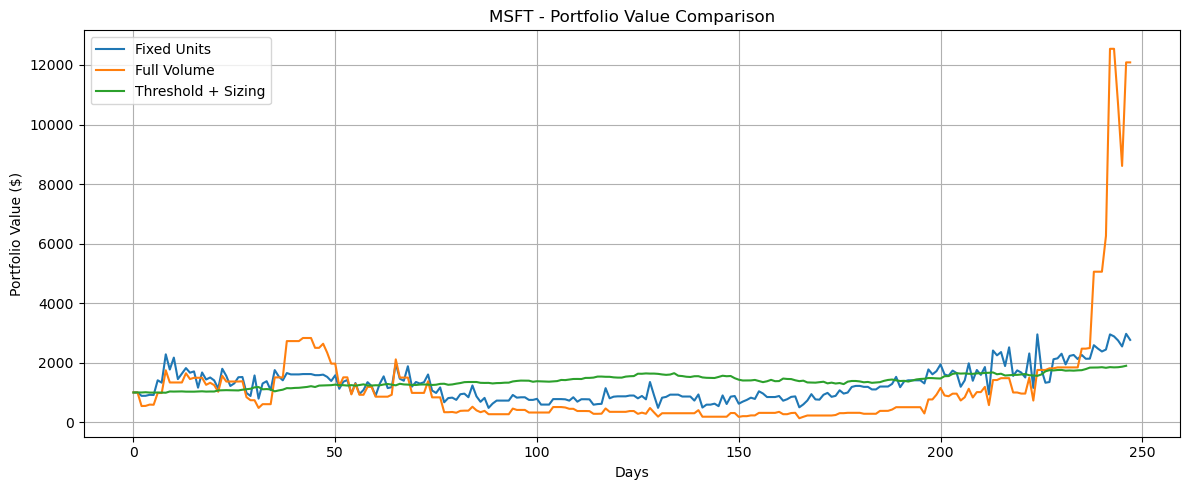

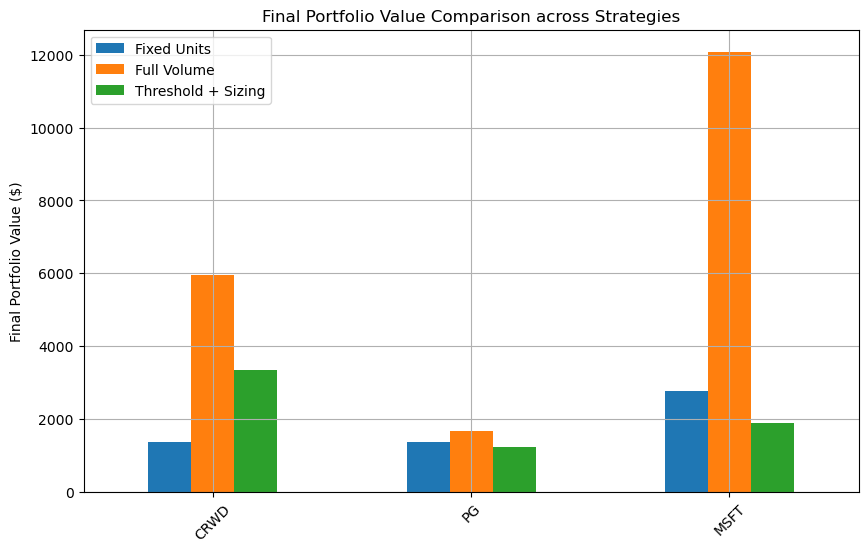

<Figure size 1200x600 with 0 Axes>

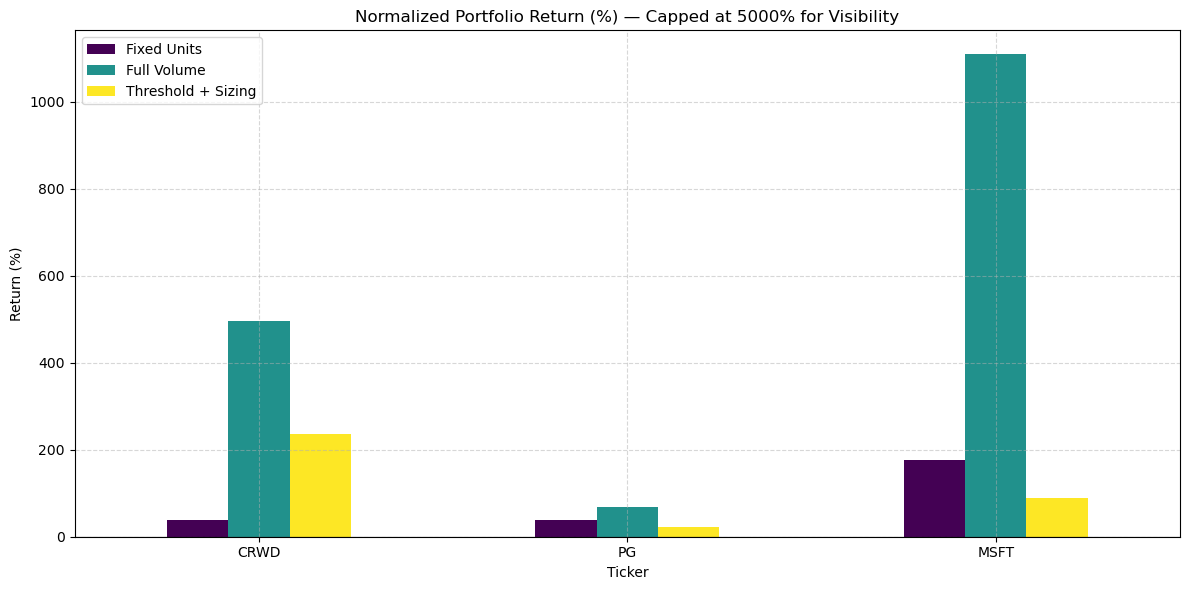

,Fixed Units,Full Volume,Threshold + Sizing
CRWD,1374.64,5962.30,3352.05
PG,1376.24,1675.13,1231.86
MSFT,2765.33,12086.87,1896.06


In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# Your tickers and results loop
tickers = ["CRWD", "PG", "MSFT"]
results = {}

for ticker in tickers:
    print(f"\n🚀 Evaluating: {ticker}")
    try:
        fixed_val, full_val, thresh_val = evaluate_strategy(ticker)
        results[ticker] = {
            "Fixed Units": fixed_val,
            "Full Volume": full_val,
            "Threshold + Sizing": thresh_val
        }
    except Exception as e:
        print(f"⚠️ Skipping {ticker} due to error: {e}")

# Convert to DataFrame
summary_df = pd.DataFrame(results).T

# ✅ Force numeric conversion
summary_df = summary_df.apply(pd.to_numeric, errors="coerce")

# ✅ Drop rows/columns that are all NaN
summary_df = summary_df.dropna(how="all", axis=0)
summary_df = summary_df.dropna(how="all", axis=1)


summary_df = pd.DataFrame(results).T
summary_df.plot(kind="bar", figsize=(10, 6))
plt.title("Final Portfolio Value Comparison across Strategies")
plt.ylabel("Final Portfolio Value ($)")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

    # Plot normalized values

initial_cash = 1000

# Normalize to % return
normalized_df = ((summary_df - initial_cash) / initial_cash) * 100

# ✅ Clip the outliers for better plot scaling
clipped_df = normalized_df.clip(upper=5000)  # cap max at +5000% return

# Plot
plt.figure(figsize=(12, 6))
clipped_df.plot(kind="bar", figsize=(12, 6), colormap="viridis")
plt.title("Normalized Portfolio Return (%) — Capped at 5000% for Visibility")
plt.ylabel("Return (%)")
plt.xlabel("Ticker")
plt.xticks(rotation=0)
plt.grid(True, linestyle="--", alpha=0.5)
plt.axhline(0, color="black", linewidth=0.8)
plt.tight_layout()
plt.show()


# ✅ Print the result table
summary_df
